In [1]:
from sklearn.datasets import fetch_openml
from sklearn import set_config

In [2]:
set_config(display = 'diagram')

In [3]:
mnist = fetch_openml('mnist_784', as_frame = False)

In [4]:
X, y = mnist.data, mnist.target

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [7]:
import matplotlib.pyplot as plt

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

In [43]:
some_digit = X[0]
# some_digit

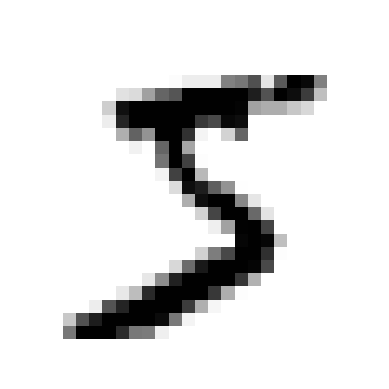

In [10]:
plot_digit(some_digit)
plt.show()

In [11]:
y[0]

'5'

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [13]:
## create target vector for classinfing images as 5
y_train_5 = (y_train == '5')
y_test_5  = (y_test == '5')

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [20]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.90965, 0.90965, 0.90965])

In [21]:
## Manually Implementing Cross Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold   = X_train[test_index]
    y_test_fold   = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


## Confusion Matrix

In [22]:
from sklearn.model_selection import cross_val_predict

In [27]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall

In [26]:
from sklearn.metrics import precision_score, recall_score

In [28]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [29]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [33]:
y_scores = sgd_clf.decision_function([some_digit])

In [35]:
y_scores

array([2164.22030239])

In [36]:
threshold = 0

In [38]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [39]:
threshold = 200000

In [41]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])